In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7

--2021-09-30 18:15:01--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2021-09-30 18:15:01--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | failed with initial 

In [3]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Descriptors, MolFromSmiles, MolToSmiles, rdmolops, QED, AllChem, rdDepictor, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.rdchem import RWMol
from rdkit.six import iteritems
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.six.moves import cPickle

# from fcd import load_ref_model


# extremely large value
INF = 1e+6

In [4]:
def setBFSorder(mol, start_id=0):
    index = {}
    bfs_queue = [start_id]
    visited_node = [start_id]
    ind_counter = 1

    while len(bfs_queue) > 0:
        c_node = bfs_queue[0]
        index[c_node] = ind_counter
        ind_counter += 1
        bfs_queue = bfs_queue[1:]

        for atom in mol.GetAtomWithIdx(c_node).GetNeighbors():
            id = atom.GetIdx()
            if id not in visited_node:
                bfs_queue.append(id)
                visited_node.append(id)

    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(index[i])

    return mol

def DrawMol(mol, size=(500, 500), filename="sample.svg"):
    # for atom in mol.GetAtoms():
    #   if atom.GetAtomMapNum() > 0:
    #     print(atom.GetAtomMapNum())
    #     atom.SetProp("_displayLabel", f"{atom.GetSymbol()}<sub>{atom.GetAtomMapNum()}</sub>")

    view = rdMolDraw2D.MolDraw2DSVG(size[0], size[1], size[0], size[1])
    rdDepictor.Compute2DCoords(mol)
    view.DrawMolecule(mol)
    view.FinishDrawing()
    svg = view.GetDrawingText()
    
    return svg
  
def rm_atom(mol, rm_list):
    remove_atom_ids = []
    att_atom_mids = []
    for atom in mol.GetAtoms():
        mid = atom.GetAtomMapNum()
        nei_map_ids = [natom.GetAtomMapNum() for natom in atom.GetNeighbors()]

        if mid in rm_list:
            remove_atom_ids.append(atom.GetIdx())

            if len(set(nei_map_ids)-set(rm_list)) > 0:
                att_atom_mids.extend(list(set(nei_map_ids)-set(rm_list)))

    remove_atom_ids.sort(reverse=True)
    rwmol = RWMol(mol)
    for i in remove_atom_ids:
        rwmol.RemoveAtom(i)

    for atom in mol.GetAtoms():
        if atom.GetAtomMapNum() in att_atom_mids:
            new_idx = rwmol.AddAtom(Chem.Atom("*"))
            rwmol.AddBond(atom.GetIdx(), new_idx, Chem.BondType.SINGLE)

    rwmol.UpdatePropertyCache(strict=True)

    return rwmol.GetMol()

def clear_atommap(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)

    return mol

[CH3:1][n:2]1[cH:3][c:5]([C:8](=[O:12])[NH:13][c:15]2[cH:16][cH:18][cH:21][cH:19][c:17]2[C:20](=[O:22])[NH:23][CH2:24][CH2:25][c:26]2[cH:27][cH:29][cH:31][cH:30][cH:28]2)[c:9](=[O:14])[c:7]2[n:4]1[cH:6][cH:10][cH:11]2


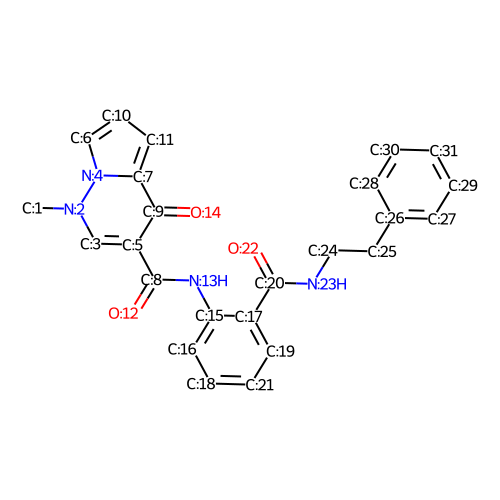

In [5]:
smiles = "Cn1cc(C(=O)Nc2ccccc2C(=O)NCCc2ccccc2)c(=O)c2cccn21"
mol = Chem.MolFromSmiles(smiles)
mol = setBFSorder(mol)
print(Chem.MolToSmiles(mol))

svg = DrawMol(mol)
SVG(svg)

In [6]:
rm_list =[
  [25, 26, 27, 28, 29, 30, 31],
  [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14],
]

*c1cccc(C(=O)NCCc2ccccc2)c1NC=O


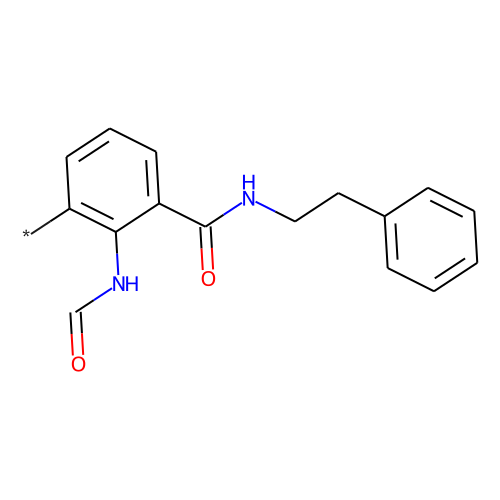

In [7]:
mol_rm = rm_atom(mol, rm_list[1])
mol_rm = clear_atommap(mol_rm)
print(Chem.MolToSmiles(mol_rm))
svg = DrawMol(mol_rm)
SVG(svg)